In [1]:
# Импортируем либы
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

import seaborn as sns

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
connection_default = {'host': '*******',
                      'database':'*******',
                      'user':'*******', 
                      'password':'*******'
                     }

In [4]:
# Объявляем параметры подключения к clickhouse
connection_test = dict(database='test',
                  host=''*******',
                  user='test',
                  password='test')

In [5]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        UserID 
    FROM 
        {db}.checks 
    LIMIT 10
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,UserID
0,18446583642950580515
1,18446535622689003675
2,18446130411954852964
3,18446003252714243011
4,18445948434655311802
5,18445927732647659917
6,18445761122620052505
7,18445655133428855896
8,18445587876544434519
9,18445586451093345117


In [6]:
# создаем таблицу с помощью CREATE TABLE
q = """
CREATE TABLE test.example_table (
    id UInt32,
    supplementary_id UInt32,
    comments String 
) 
ENGINE = MergeTree 
ORDER BY (id, supplementary_id)
"""

# ph.execute(query=q, connection=connection_test)

In [7]:
q = '''
    SELECT 
        * 
    FROM 
        test.example_table
    LIMIT 10
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_test)
q_test

,id,supplementary_id,comments


## ETL
с помощью `pandahouse` попробуем выгрузить нужные данные из `ClickHouse` и проанализируем их в `python`. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

`ldn_listings` – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

## Для начала,
проверим правильность подключения к ClickHouse через `pandahouse`, отправив простой запрос:

In [8]:
q = '''
    SELECT
        COUNT(*)

    FROM 
        default.ldn_listings
    '''

In [9]:
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


In [10]:
ph.execute(query=q, connection=connection_default)

b'85207\n'

## Выгрузим из таблицы данные о цене в зависимости от типа жилья.
Необходимые столбцы:

- `price` – цена за ночь
- `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- выводим первые 1000 строк.

Сгруппируем полученный датафрейм по типу жилья и посчитаем 75-й перцентиль цены.

In [11]:
q = '''
    SELECT
        id,
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price

    FROM 
        default.ldn_listings
        
    ORDER BY
        id ASC
        
    LIMIT 1000
    '''

In [12]:
df1 = ph.read_clickhouse(query=q, connection=connection_default)
df1.head()

,id,room_type,price
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0


In [13]:
df1.describe()

,id,price
count,1000.000000,1000.000000
mean,341803.999000,105.191002
std,146518.557054,123.240166
min,13913.000000,12.000000
25%,251768.500000,45.000000
50%,387980.000000,75.500000
75%,458607.250000,125.000000
max,542754.000000,2000.000000


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1000 non-null   uint32 
 1   room_type  1000 non-null   object 
 2   price      1000 non-null   float32
dtypes: float32(1), object(1), uint32(1)
memory usage: 15.8+ KB


In [15]:
# Альтернативный подход
# df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()
# df[df['room_type'] == 'Private room']

df1.query("room_type == 'Private room'").price.quantile(q=0.75)

70.0

## Дополнительные данные о рейтинге жилья
К данным о цене и типе комнаты дополнительно выгрузим данные о рейтинге жилья (`review_scores_rating`).

В запросе необходимо будет отфильтровать пустые значения `review_scores_rating` и сконвертировать эту колонку в тип `float32`.

Построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Разделим на этапы:

1) сгруппируем датафрейм по типу жилья и посчитаем среднее для цены и рейтинга

2) используем `sns.scatterplot`, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр `hue`)



In [16]:
q = '''
    SELECT
        id,
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating

    FROM 
        default.ldn_listings
    
    WHERE review_scores_rating is not null 
    
    ORDER BY
        id ASC
        
    LIMIT 1000
    '''

In [17]:
df2 = ph.read_clickhouse(query=q, connection=connection_default)
df2.head()

,id,room_type,price,review_scores_rating
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0


In [18]:
data = (df2
            .groupby('room_type')
            .agg({'price': ['mean'], 'review_scores_rating': ['mean']})
            .reset_index()       
       )
data.columns = ['room_type', 'price', 'review_scores_rating']
data

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


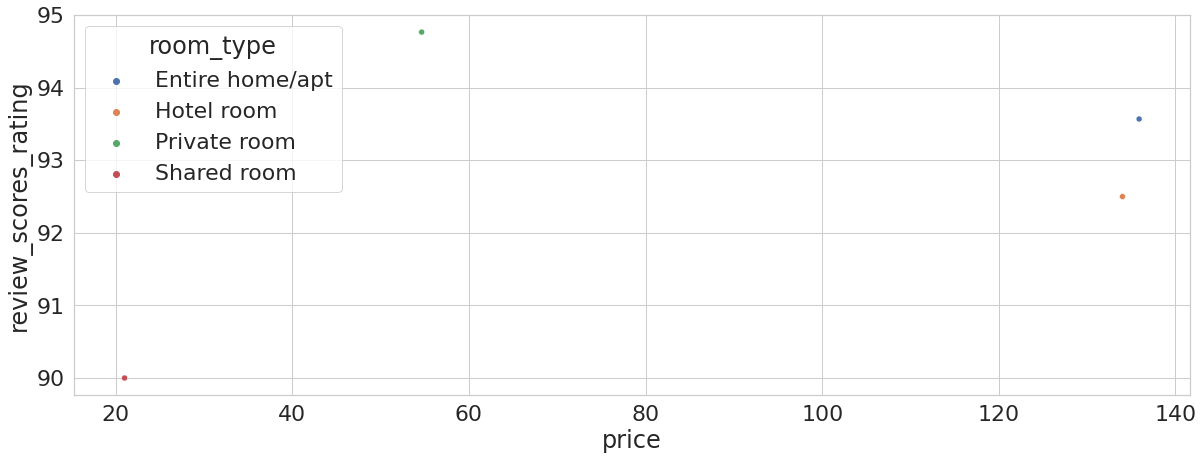

In [19]:
sns.scatterplot(data=data, x='price', y='review_scores_rating', hue='room_type')

Среди представленных ниже графиков выберите корректный:
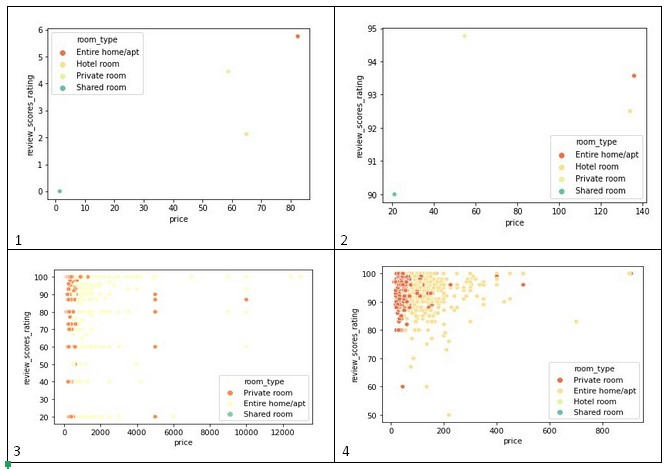

## ВПЕЧАТЛЕНИЯ
Итак, помимо аренды жилья, на Airbnb также есть ["Впечатления"](https://blog.atairbnb.com/what-are-airbnb-experiences-ru/) — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (`experiences_offered != 'none'`).

Для каждого уникального пользователя выгрузим:

- `host_id` – идентификатор хозяина (уникальный)
- `host_verifications` – какими способами хост подтвердил свой профиль

**Затем обработаем столбец `host_verifications`**:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведем их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
    ~~~Python
    "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']
    ~~~

2. Используем методы `explode` и `value_counts`, чтобы посчитать, сколько раз встречается каждый способ верификации


In [20]:
q = """
    SELECT
        DISTINCT host_id,
        host_verifications

    FROM
        default.ldn_listings

    WHERE
        experiences_offered != 'none'
    """

In [21]:
# Выгружаем данные из базы
df3 = ph.read_clickhouse(query=q, connection=connection_default)

# Приводим данные в колонке в нужный тип
df3.host_verifications = df3.host_verifications.apply(lambda x: eval(x))

# Распаковываем списки для каждого host_id
df3 = df3.explode('host_verifications')

In [22]:
data = df3.host_verifications.value_counts()
data

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

### **Сколько хозяев подтвердили профиль с помощью аккаунта Google?**

In [23]:
data.loc['google']

34


Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.

Сгруппируем данные по району и виду впечатления и посчитаем количество объявлений. Новый столбец назовем `experiences_count`.

- Отсортируем данные по убыванию `experiences_count` и выгрузим первые `100` строк.
- Затем преобразуем данные с помощью `pivot`,
    - поместив в индексы название района,
    - столбцы – вид впечатления,
    - а значения – число объявлений с таким впечатлением для каждого района.
    
- Визуализируем результат с помощью `sns.heatmap()` c палитрой `cmap=sns.cubehelix_palette(as_cmap=True)`. 

In [24]:
q = """
    SELECT
        neighbourhood_cleansed,
        experiences_offered,
        COUNT(*) AS experiences_count

    FROM
        default.ldn_listings

    WHERE experiences_offered != 'none'

    GROUP BY
        neighbourhood_cleansed,
        experiences_offered

    ORDER BY
        experiences_count DESC

    LIMIT 100
    """

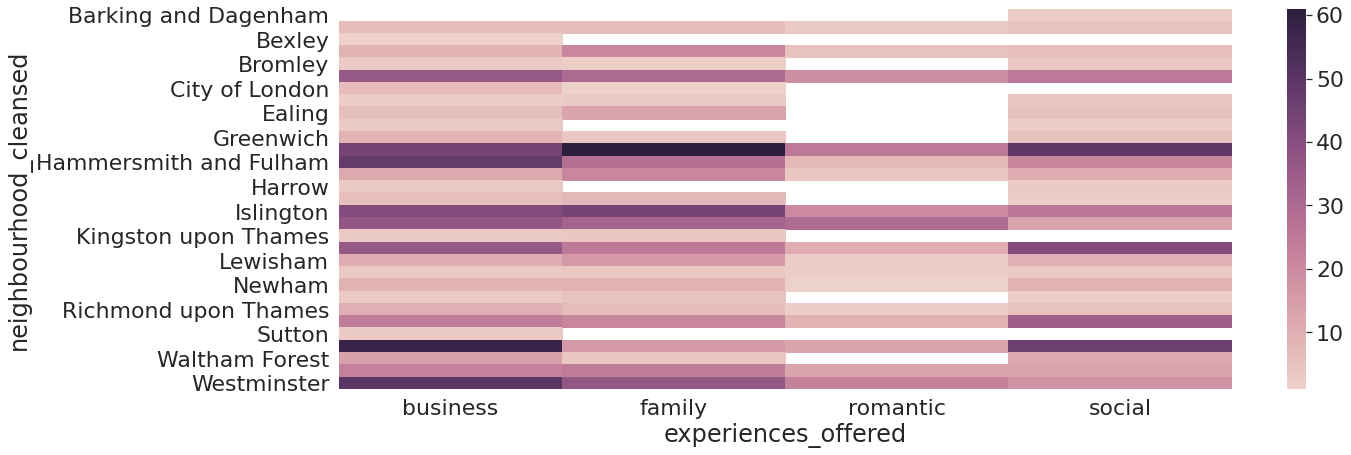

In [25]:
# Выгружаем данные из базы
df4 = ph.read_clickhouse(query=q, connection=connection_default)

# Готовим данные к визуализации
data = df4.pivot(index='neighbourhood_cleansed',
                 columns='experiences_offered',
                 values='experiences_count'
                )

# Визуализируем
sns.heatmap(data=data,
            cmap=sns.cubehelix_palette(as_cmap=True)
           )


Выгруим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.

Необходимые для составления запроса столбцы:

- `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- `price` – цена за ночь 
- `experiences_offered` – вид доступного впечатления

Далее постройим два графика, используя `distplot` из библиотеки `seaborn`:
- На первом отобразим исходные распределения цен для каждого типа жилья
- На втором – логарифмированные значения (`np.log()`)

In [26]:
q = """
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price

    FROM
        default.ldn_listings

    WHERE experiences_offered != 'none'
    """

In [27]:
# Выгружаем данные из базы
df5 = ph.read_clickhouse(query=q, connection=connection_default)

In [28]:
df5.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


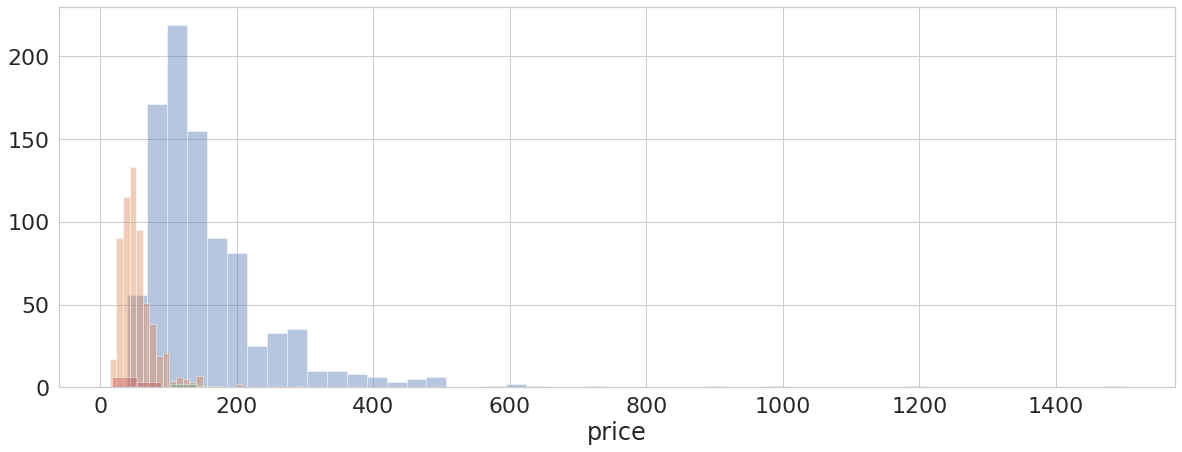

In [29]:
sns.distplot(df5.query("room_type == 'Entire home/apt'").price, kde=False)
sns.distplot(df5.query("room_type == 'Private room'").price, kde=False)
sns.distplot(df5.query("room_type == 'Hotel room'").price, kde=False)
sns.distplot(df5.query("room_type == 'Shared room'").price, kde=False)

In [30]:
df5['price_log'] = np.log(df5.price)
df5.head()

,room_type,price,price_log
0,Private room,65.0,4.174387
1,Entire home/apt,100.0,4.605170
2,Private room,150.0,5.010635
3,Private room,45.0,3.806663
4,Private room,25.0,3.218876


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


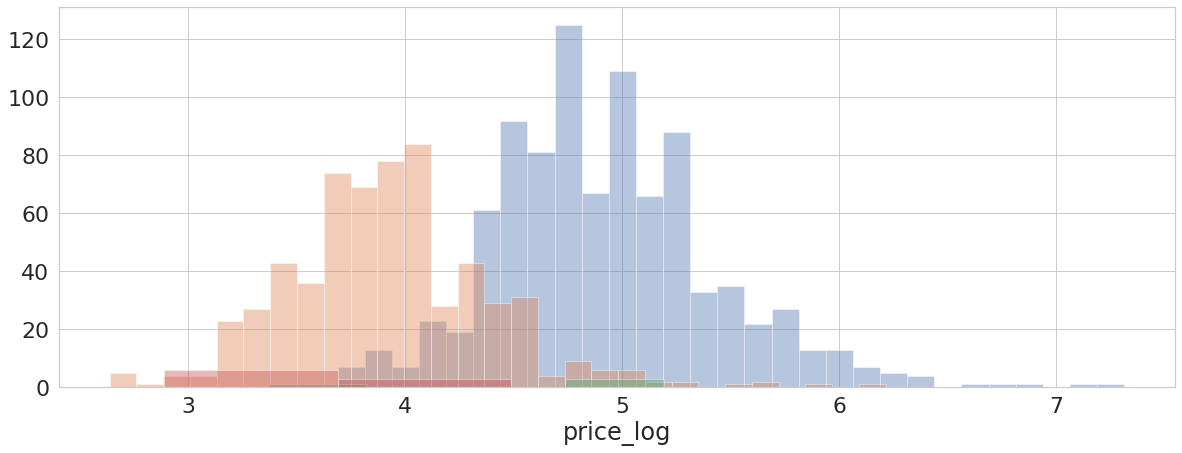

In [31]:
sns.distplot(df5.query("room_type == 'Entire home/apt'").price_log, kde=False, label='Entire home/apt')
sns.distplot(df5.query("room_type == 'Private room'").price_log, kde=False, label='Private room')
sns.distplot(df5.query("room_type == 'Hotel room'").price_log, kde=False, label='Hotel room')
sns.distplot(df5.query("room_type == 'Shared room'").price_log, kde=False, label='Shared room')

## ДИНАМИКА ЦЕН

Выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со `2 января 2010 года`.

Необходимые столбцы:

- `room_type` – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- `price` – цена за ночь
- `first_review` – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")


Используя библиотеку `seaborn` и функцию `lineplot`, построим график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр `hue`) по годам (ось X). 


In [32]:
q = """
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        first_review

    FROM
        default.ldn_listings

    WHERE  first_review > '2010-01-01'

    LIMIT 1000
    """

In [33]:
# Выгружаем данные из базы
df6 = ph.read_clickhouse(query=q, connection=connection_default)

# Добавляем маркер года
df6['year'] = pd.to_datetime(df6.first_review).dt.year

# Сортируем по дате
df6 = df6.sort_values('first_review').reset_index(drop=True)

In [34]:
# Готовим данные под визуализацию
data = df6.groupby(['room_type', 'year'], as_index=False).agg({'price': 'mean'})

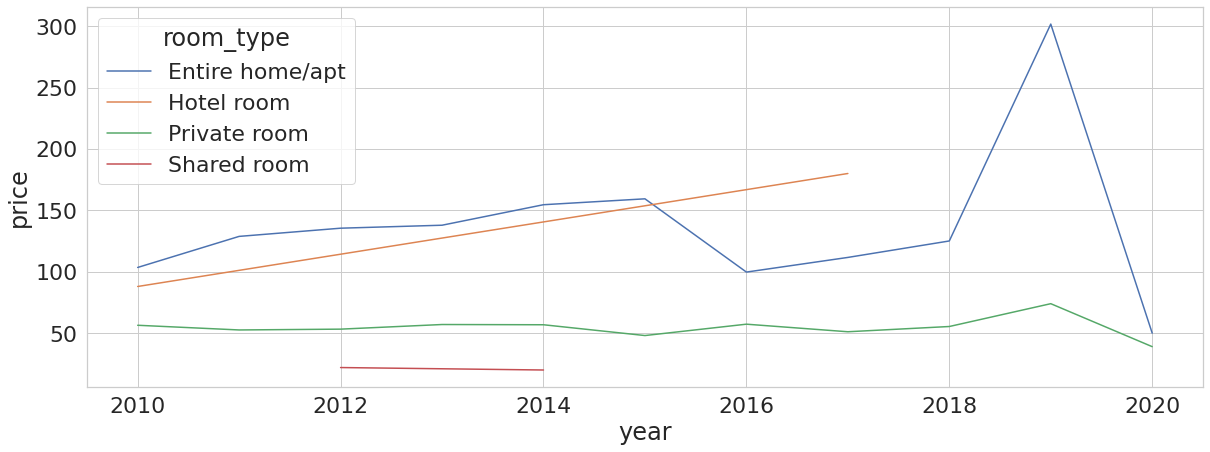

In [35]:
sns.lineplot(data=data, y='price', x='year', hue='room_type')